In [16]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt
import numpy as np

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Prepare dataset with shuffle enabled
data = tf.keras.utils.image_dataset_from_directory(
    './data/Combined/', 
    image_size=(256, 256),
    color_mode='rgb', 
    batch_size=32, 
    shuffle=True  # Shuffle data
)

# Data Augmentation: Applied to the training data using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split sizes
train_size = 0.7  # 70% training data
val_size = 0.15   # 15% validation data
test_size = 0.15  # 15% test data

# Calculate the number of batches in the dataset
total_batches = tf.data.experimental.cardinality(data).numpy()

train_batches = int(total_batches * train_size)
val_batches = int(total_batches * val_size)
test_batches = int(total_batches * test_size)

# Split the dataset using the calculated sizes
train = data.take(train_batches)
val_test = data.skip(train_batches)
val = val_test.take(val_batches)
test = val_test.skip(val_batches)

# Optionally, prefetch the data for better performance
train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val = val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test = test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Apply data augmentation only to the training set
train = train.map(lambda x, y: (tf.image.random_flip_left_right(x), y))

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Unfreeze the top layers of the base model
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Build the model with regularization, batch normalization, and additional layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # More efficient than Flatten()
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 9 classes
])

# Compile the model with learning rate scheduler
initial_learning_rate = 1e-3
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * 10 ** (-epoch / 20))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# TensorBoard callback for visualization
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)

# Train the model
hist = model.fit(
    train, 
    epochs=50, 
    validation_data=val, 
    callbacks=[early_stopping, tensorboard_callback, lr_schedule, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test)
print(f'Test accuracy: {test_acc:.4f}')

# Ensure the directory exists
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model to the 'models' directory
model_path = os.path.join(model_dir, 'palm_tree_health_model.h5')
model.save(model_path)
print(f'Model saved to {model_path}')


Found 3944 files belonging to 10 classes.


/var/folders/n9/t793s4995b354q_1jpbvkkl40000gn/T/ipykernel_49980/1330289951.py:65: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 407s 5s/step - accuracy: 0.2390 - loss: 3.9230 - val_accuracy: 0.1198 - val_loss: 41.6870 - learning_rate: 0.0010
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.5021 - loss: 2.7386 - val_accuracy: 0.1632 - val_loss: 11.0984 - learning_rate: 8.9125e-04
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.6189 - loss: 2.2480 - val_accuracy: 0.1267 - val_loss: 16.9117 - learning_rate: 7.9433e-04
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 415s 5s/step - accuracy: 0.7113 - loss: 1.9189 - val_accuracy: 0.1927 - val_loss: 16.4322 - learning_rate: 7.0795e-04
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - accuracy: 0.7467 - loss: 1.7656 - val_accuracy: 0.3003 - val_loss: 7.4253 - learning_rate: 6.3096e-04
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 424s 5s/step - accuracy: 0.8186 - loss: 1.5403 - val_accuracy: 0.2795 - val_loss: 9.0808 - learning_rate: 5.6234e-04
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 514s 6s/step - accuracy: 0.8474 

Test accuracy: 0.9205
Model saved to models/palm_tree_health_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


2024-09-22 20:39:02.705126: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


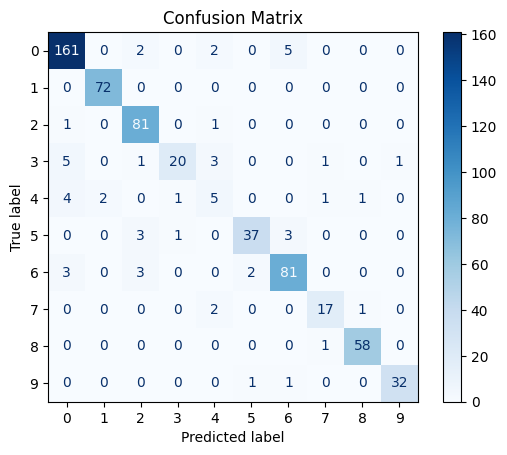

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test:  # Iterate over the test dataset batches
    predictions = model.predict(images)  # Get the predictions
    predicted_labels = np.argmax(predictions, axis=1)  # Get the class with the highest probability
    
    y_true.extend(labels.numpy())  # Append true labels
    y_pred.extend(predicted_labels)  # Append predicted labels

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


In [22]:
import os

def count_images_in_directory(directory_path):
    # Supported image formats
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

    # Check if the provided path is a valid directory
    if not os.path.isdir(directory_path):
        print(f"The provided path '{directory_path}' is not a valid directory.")
        return

    # Count the number of images
    image_count = 0
    for file_name in os.listdir(directory_path):
        file_extension = os.path.splitext(file_name)[1].lower()  # Get the file extension and make it lowercase
        if file_extension in image_extensions:
            image_count += 1

    print(f"Number of images in '{directory_path}': {image_count}")

# Example usage
count_images_in_directory('/Users/nfk/model/data/Combined/1. Potassium Deficiency')


Number of images in '/Users/nfk/model/data/Combined/3. Magnesium Deficiency': 605


In [29]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are already collected from the test set
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       170
           1       0.97      1.00      0.99        72
           2       0.90      0.98      0.94        83
           3       0.91      0.65      0.75        31
           4       0.38      0.36      0.37        14
           5       0.93      0.84      0.88        44
           6       0.90      0.91      0.91        89
           7       0.85      0.85      0.85        20
           8       0.97      0.98      0.97        59
           9       0.97      0.94      0.96        34

    accuracy                           0.92       616
   macro avg       0.87      0.85      0.85       616
weighted avg       0.91      0.92      0.91       616

